In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import glob as gb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau



In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aliibrahim20034","key":"4cd41367c678f12bd68e3dd47c5c3da6"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:

!kaggle datasets download -d tolgadincer/labeled-chest-xray-images -p ./chest_xray_data
!unzip -q ./chest_xray_data/labeled-chest-xray-images.zip -d ./chest_xray_data/

Dataset URL: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images
License(s): other
 98% 1.15G/1.17G [00:05<00:00, 262MB/s]
100% 1.17G/1.17G [00:05<00:00, 240MB/s]


In [5]:
!find intel_data -maxdepth 2 -type f | head -20

find: ‘intel_data’: No such file or directory


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_data_gen = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    validation_split=0.1,
                                    )
test_data_gen = ImageDataGenerator(rescale=1./255)
train_generator = train_data_gen.flow_from_directory(
    '/content/chest_xray_data/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training')
test_generator = test_data_gen.flow_from_directory(
    '/content/chest_xray_data/chest_xray/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')
val_generator = train_data_gen.flow_from_directory(
    '/content/chest_xray_data/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation')


Found 4710 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 522 images belonging to 2 classes.


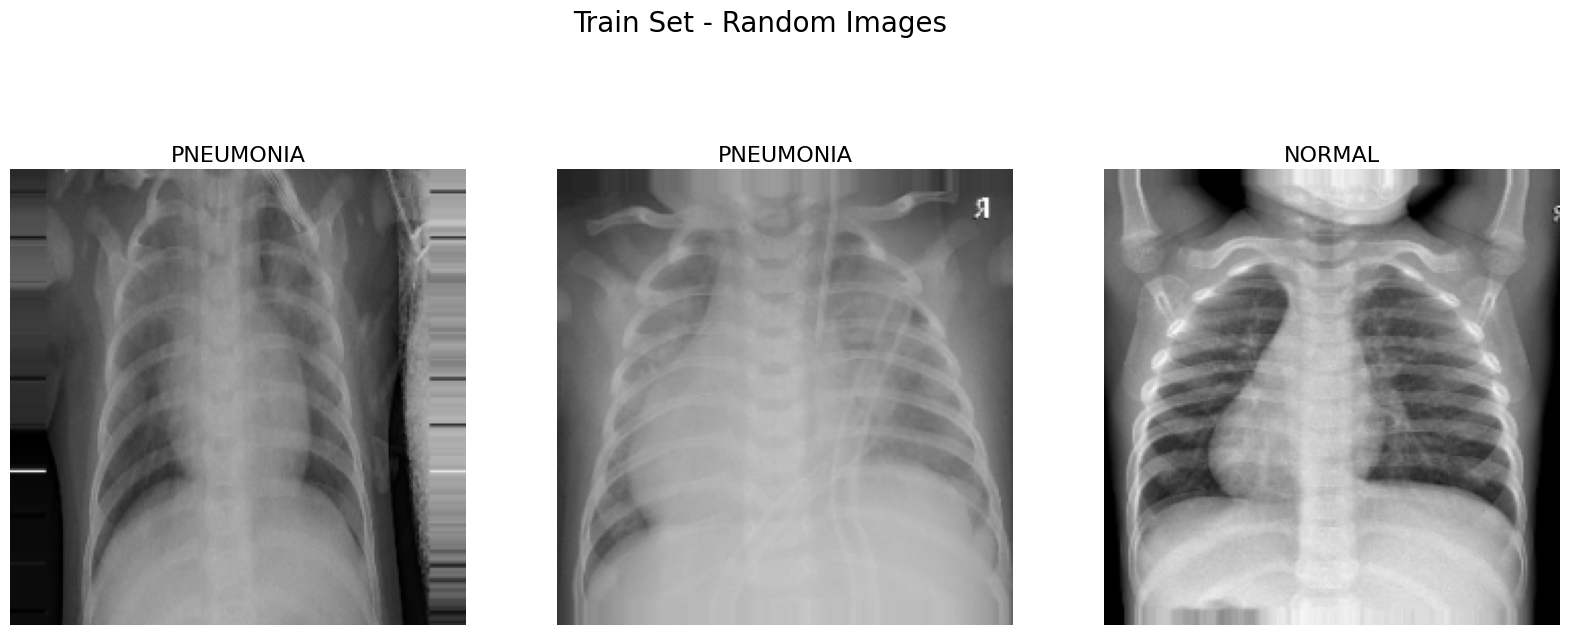

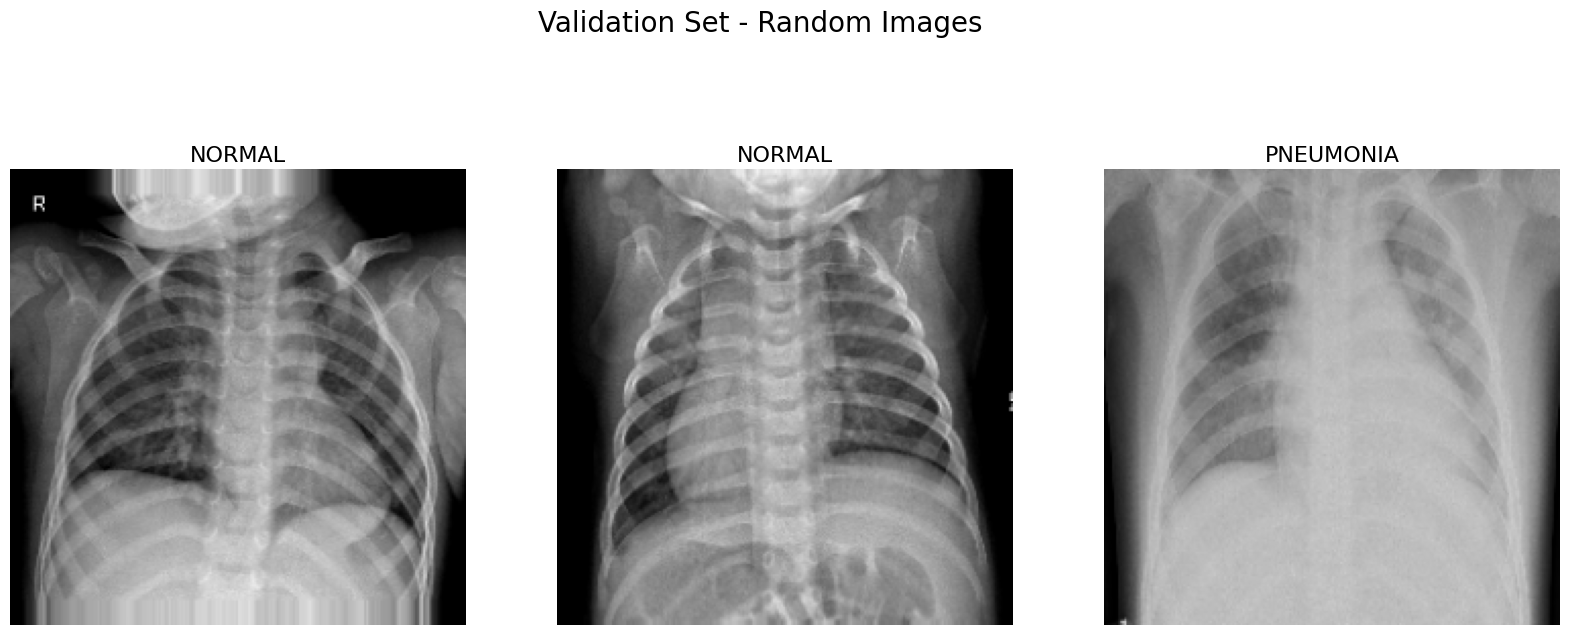

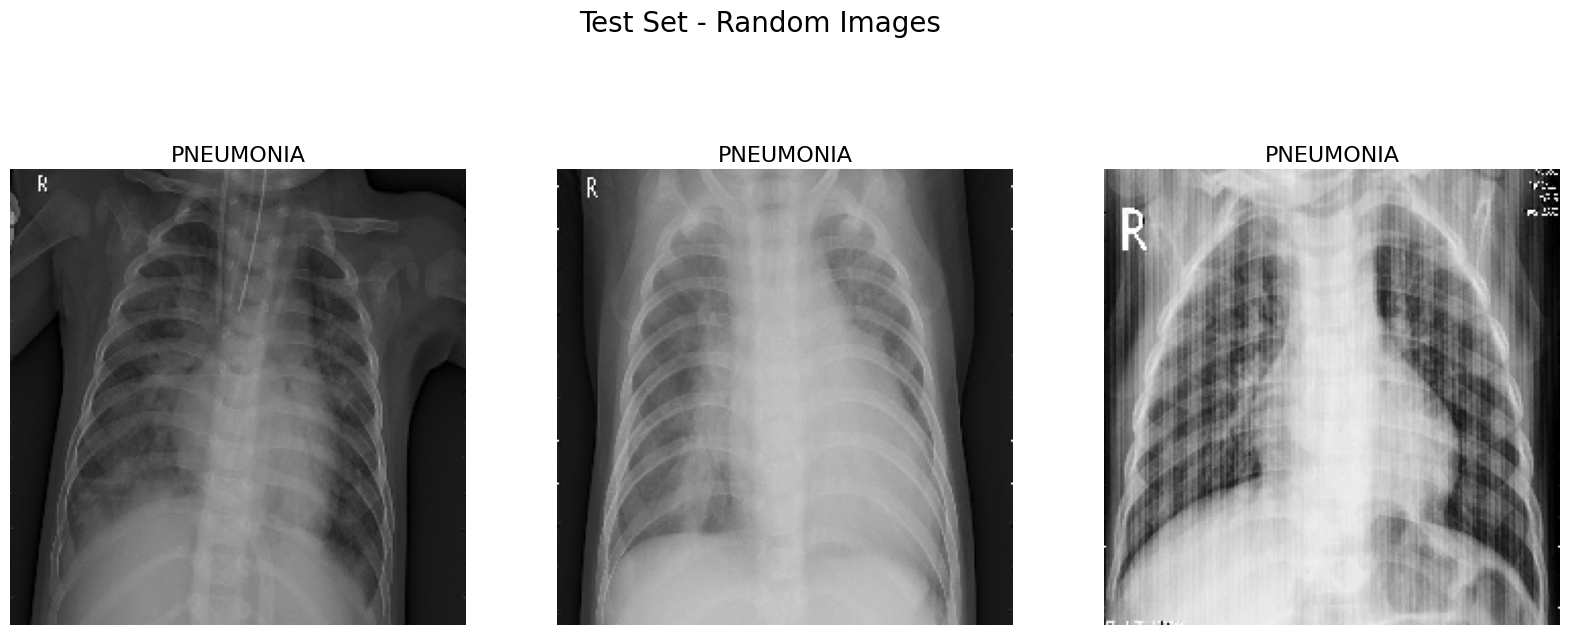

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_random_images_with_labels(generator, title):
    images, labels = next(generator)
    class_labels = list(generator.class_indices.keys())

    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    fig.suptitle(title, fontsize=20)

    random_indices = np.random.choice(len(images), 3, replace=False)

    for i, idx in enumerate(random_indices):
        axes[i].imshow(images[idx])
        axes[i].axis('off')
        label_index = int(labels[idx])  # 0 or 1
        axes[i].set_title(class_labels[label_index], fontsize=16)

    plt.show()

# عرض صور عشوائية
plot_random_images_with_labels(train_generator, 'Train Set - Random Images')
plot_random_images_with_labels(val_generator, 'Validation Set - Random Images')
plot_random_images_with_labels(test_generator, 'Test Set - Random Images')

In [33]:


# Callbacks
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='CNN.weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)


vgg_base = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

vgg_base.trainable = False

model = tf.keras.Sequential([
    vgg_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [18]:
history=model.fit(train_generator,epochs=20,validation_data=val_generator,callbacks=[model_checkpoint_callback,early_stopping_callback,reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 129s 783ms/step - accuracy: 0.7934 - loss: 0.4445 - val_accuracy: 0.9157 - val_loss: 0.2308 - learning_rate: 0.0010
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 105s 708ms/step - accuracy: 0.8924 - loss: 0.2488 - val_accuracy: 0.9253 - val_loss: 0.2007 - learning_rate: 0.0010
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 105s 712ms/step - accuracy: 0.9083 - loss: 0.2095 - val_accuracy: 0.9368 - val_loss: 0.1673 - learning_rate: 0.0010
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 107s 720ms/step - accuracy: 0.9151 - loss: 0.1999 - val_accuracy: 0.9291 - val_loss: 0.1753 - learning_rate: 0.0010
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 110s 743ms/step - accuracy: 0.9315 - loss: 0.1788 - val_accuracy: 0.9406 - val_loss: 0.1512 - learning_rate: 0.0010
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 104s 705ms/step - accuracy: 0.9285 - loss: 0.1800 - val_accuracy: 0.9330 - val_loss: 0.1622 - learning_rate: 0.0010
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 105s 711ms/step - accura

In [20]:
model.evaluate(test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 694ms/step - accuracy: 0.9228 - loss: 0.1915


[0.19178417325019836, 0.9294871687889099]

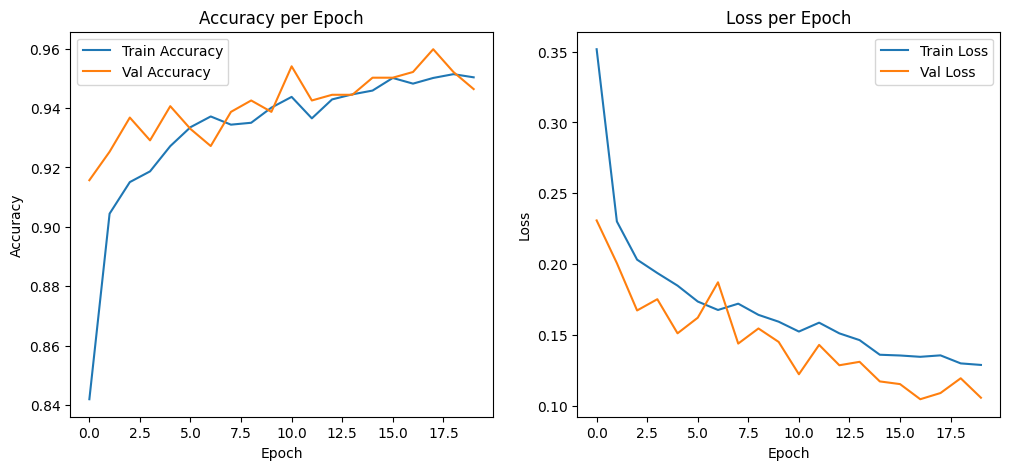

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [22]:
model.save('model_vgg.h5')